In [17]:
import numpy as np
import torch
import utility.dataset as dataset
from utility.preprocessing import preprocessing
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import random

In [18]:
global_models = []
local_results = []
global_results = []
tasks_data_info = []
tasks_data_idx = []

# experiment settings
type_iid=["noniid"]
task_type = ["mnist"]
num_clients = 20
class_ratio=[0.21]
active_rate = 0.2
class ARGS:
    def __init__(self):
        global num_clients
        self.num_clients = num_clients
        self.unbalance = [1.0, 1.0]  # [0]% of clients have [1]% of data
args = ARGS()
random_seed = 18796
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)



for i in range(len(task_type)):
    tasks_data_info.append(preprocessing(task_type[i], data_ratio=1.0, args=args)) # 0: trainset, 1: testset, 2: min_data_num, 3: max_data_num 4: input_size, 5: classes_size
    if type_iid[i] =='iid':
        tasks_data_idx.append(dataset.iid(dataset=tasks_data_info[i][0],
                                        min_data_num=tasks_data_info[i][2],
                                        max_data_num=tasks_data_info[i][3],
                                        num_users=num_clients)) # 0: clients_data_idx
    elif type_iid[i] =='noniid':
        tasks_data_idx.append(dataset.noniid(dataset=tasks_data_info[i][0],
                            min_data_num=tasks_data_info[i][2],
                            max_data_num=tasks_data_info[i][3],
                            class_ratio=class_ratio[i],
                            num_users=num_clients))


/Users/haoranzhang/Downloads/FL-cluster-sampling/utility/dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


In [19]:
def get_gradient(weights_this_round, weights_next_round): 
    # get gradient by subtracting weights_next_round from weights_this_round
    weight_diff = {name: (weights_this_round[name] - weights_next_round[name]).cpu() for name in weights_this_round}
    return weight_diff

def loss_sampling(m, clients):
    # sample m clients with lowest accuracy
    acc_list = []
    for i in range(len(clients)):
        acc_list.append(clients[i].get_training_accuracy())
    acc_list = np.array(acc_list)
    idx = np.argsort(acc_list)
    idx = idx[:m]
    active_clients = [clients[i] for i in idx]
    return active_clients

def cluster_sampling(active_num, clients, cluster_result):
    len_cluster = [len(cluster) for cluster in cluster_result]
    client_num  = len(clients)
    active_num_cluster = [int(active_num * len_cluster[i] / client_num) for i in range(len(len_cluster))]
    active_clients_list = []
    for i, cluster_clients in enumerate(cluster_result):
        active_clients_list.extend(loss_sampling(m=active_num_cluster[i], clients=cluster_clients))

    return active_clients_list

def flatten_params(state_dict):
    flattened_weights = np.concatenate([param.flatten() for param in state_dict])
    return flattened_weights

def cosine_similarity(state_dict1, state_dict2):
    """Compute the cosine similarity between two model state dictionaries."""
    vec1 = flatten_params(state_dict1)
    vec2 = flatten_params(state_dict2)
    # convert vec1 and vec2 to torch tensors
    vec1 = torch.tensor(vec1)
    vec2 = torch.tensor(vec2)
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    if norm1 > 0 and norm2 > 0:
        return dot_product / (norm1 * norm2)
    else:
        return 0.0


In [20]:
class MnistMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistMLP, self).__init__()
        self.in_size = 28 * 28
        self.hidden_size = 100
        self.out_size = num_classes
        self.net = nn.Sequential(
            nn.Linear(in_features=self.in_size, out_features=self.hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
        )
        for m in self.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_normal_(m.weight)

    def forward(self, batch):
        batch = batch.view(batch.size(0),-1)
        return torch.squeeze(self.net(batch))

In [21]:
class Client:
    def __init__(self, client_index, batch_size=256, tasks_index=0):
        global tasks_data_info, tasks_data_idx
        self.client_index = client_index
        self.tasks_data_info = tasks_data_info
        self.tasks_data_idx = tasks_data_idx
        self.batch_size = batch_size
        self.tasks_index = tasks_index # 0 is non-iid
        self.gradient = None
        self.set_data()
        self.model = MnistMLP()
        self.device = torch.device("cpu")
        self.training(epochs=10)
        # print(f"Client {client_index}; labels {self.non_iid_labels}; accuracy {np.round(self.get_training_accuracy(), 3)}")
        self.get_trained_weights()

        local_data_num = []
        for client_idx in range(num_clients):
            local_data_num.append(len(tasks_data_idx[self.tasks_index][0][client_idx]))
        self.data_fraction = len(self.loader.dataset) / sum(local_data_num)
        


        
    def set_data(self):
        if type_iid[self.tasks_index] == 'iid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][self.client_index])  # or iid_partition depending on your choice
        elif type_iid[self.tasks_index] == 'noniid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][0][self.client_index])  # or iid_partition depending on your choice
            self.non_iid_labels = self.tasks_data_idx[self.tasks_index][1][self.client_index]
        self.loader = DataLoader(client_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
    
    
    def training(self, epochs=10):
        loader = self.loader
        self.model.to(self.device)
        previous_local_state_dict = self.model.state_dict().copy()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        client_label = tasks_data_idx[self.tasks_index][1][self.client_index]


        for _ in range(epochs):
            self.model.train()
            loss = 0
            for i, (data, target) in enumerate(loader):
                optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                label_mask = torch.zeros(tasks_data_info[self.tasks_index][5], device=output.device)
                label_mask[client_label] = 1
                output = output.masked_fill(label_mask == 0, 0)
                     
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss += loss.item()
        self.gradients = get_gradient(previous_local_state_dict, self.model.state_dict())
        return self.model
    
    def get_training_accuracy(self):
        self.model.to(self.device)
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        return correct / total
    
    def get_trained_weights(self):
        # get weights
        self.weights = []
        for param in self.model.parameters():
            self.weights.append(param.data.cpu().numpy())
        self.flattened_weights = np.concatenate([w.flatten() for w in self.weights])
        # get graidents
        self.gradients = []
        for p in self.model.parameters():
            self.gradients.append(p.grad.data.cpu().numpy())
        self.flattened_gradients = np.concatenate([g.flatten() for g in self.gradients])
        # get gradident norms
        self.gradient_norms = [np.linalg.norm(g) for g in self.gradients]

    def update_to_global_weights(self, global_model):
        self.model.load_state_dict(global_model.state_dict())
    
    def get_local_weights(self):
        return self.model.state_dict()

In [22]:
class Cluster:
    def __init__(self, clients, num_clusters=5):
        self.clients = clients
        self.num_clusters = num_clusters
        # self.cluster()
        
    def cluster(self, method="gradient_norm"):
        #self.client_weights = np.array([c.flattened_weights for c in self.clients])
        #self.client_gradients = np.array([c.flattened_gradients for c in self.clients])
        #for c in self.clients:
        #    c.get_trained_weights()

        # try to use gradient similarity
        if method == "cosine":
            from sklearn.cluster import SpectralClustering
            gradient_similarity = np.ones((len(self.clients), len(self.clients)))
            for i in range(len(self.clients)):
                for j in range(i+1, len(self.clients)):
                    gradient_i = self.clients[i].gradients
                    gradient_j = self.clients[j].gradients
                    gradient_similarity[i, j] = cosine_similarity(gradient_i, gradient_j)
                    gradient_similarity[j, i] = gradient_similarity[i, j]
            print(gradient_similarity)
            clustering = SpectralClustering(n_clusters=self.num_clusters,
                                    affinity='precomputed',
                                    assign_labels='kmeans',
                                    random_state=0).fit(gradient_similarity)
            self.cluster_labels = clustering.labels_
        else:
            self.client_norms = np.array([c.gradient_norms for c in self.clients])
            self.data = self.client_norms
            self.pca = PCA(n_components=2)
            self.client_pca = self.pca.fit_transform(self.data)
            self.kmeans = KMeans(n_clusters=self.num_clusters)
            self.kmeans.fit(self.client_pca)
            self.cluster_labels = self.kmeans.labels_
            self.cluster_centers = self.kmeans.cluster_centers_
            # self.plot()
        
    def plot(self):
        plt.figure(figsize=(10, 10))
        for i in range(self.num_clusters):
            plt.scatter(self.client_pca[self.cluster_labels == i, 0], 
                        self.client_pca[self.cluster_labels == i, 1], 
                        label=f'Cluster {i}')
        for i, (x, y) in enumerate(self.client_pca):
            plt.annotate(f'Client {i}; labels {self.clients[i].non_iid_labels}', 
                         (x, y), 
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center')
        plt.legend()
        plt.show()
    
    def get_result(self):
        #return pd.DataFrame({"cluster_labels": self.cluster_labels, 
        #                     "client_index": [c.client_index for c in self.clients]})
        cluster_clients_list = []
        for cluster in range(self.num_clusters):
            cluster_clients_list.append([])
            # initialize cluster_clients_list

        for c in self.clients:
            c_index = c.client_index
            cluster = self.cluster_labels[c_index]
            cluster_clients_list[cluster].append(c)
        self.result = cluster_clients_list
        return self.result

In [23]:
class Server:
    def __init__(self, batch_size=128, tasks_index=0):
        global tasks_data_info, tasks_data_idx
        self.tasks_data_info = tasks_data_info
        self.tasks_data_idx = tasks_data_idx
        self.batch_size = batch_size
        self.tasks_index = tasks_index # 0 is non-iid
        self.test_data = self.tasks_data_info[self.tasks_index][1] # set test dataset
        self.loss_list = []
        
        self.global_model = MnistMLP()
        self.device = torch.device("cpu")
        #self.training()
        #self.get_trained_weights()
        # load global model

    def aggregation(self):
        # aggregate weights
        global_weights_state_dict = self.global_model.state_dict()
        global_keys = list(global_weights_state_dict.keys())
        for key in global_keys:
            global_weights_state_dict[key] = torch.zeros_like(global_weights_state_dict[key])

        fraction_sum = 0
        for c in self.active_clients:
            fraction_sum += c.data_fraction

        for c in self.active_clients:
            for key in global_weights_state_dict.keys():
                global_weights_state_dict[key] += c.data_fraction / fraction_sum * c.model.state_dict()[key]

        # update global model
        self.global_model.load_state_dict(global_weights_state_dict)


    def sampling(self, clients, method='random'):
        global active_rate
        active_num = int(active_rate * len(clients))
        if method == 'random':
            self.active_clients = random.sample(clients, active_num)
        elif method == 'IS':
            self.active_clients = loss_sampling(m=active_num, clients=clients)
        elif method == 'cluster':
            clusters = Cluster(clients)
            clusters.cluster()
            if (self.current_round+1) % 50 == 0:
                clusters.plot()
            cluster_result = clusters.get_result()
            self.active_clients = cluster_sampling(active_num, clients, cluster_result)
    
    def get_global_loss(self):
        testloader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)
        self.global_model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        loss = 0
        with torch.no_grad():
            for i, (data, target) in enumerate(testloader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.global_model(data)
                loss += criterion(output, target)
            loss /= len(testloader)
        # print('global loss: ', loss.item())
        return loss.item()

        

    def FL_training(self, num_clients=20, rounds=10, sampling_method='random'):
        # define clients
        from tqdm import tqdm
        clients = [Client(i) for i in range(num_clients)]

        for r in tqdm(range(rounds)):
            self.current_round = r
            # set local models weights to current global
            for c in clients:
                c.update_to_global_weights(self.global_model)
            # sampling with current global model
            self.sampling(clients, method=sampling_method)
            # train clients
            for c in self.active_clients:
                c.training(epochs=5)
            # aggregate weights
            self.aggregation()
            self.loss_list.append(self.get_global_loss())
    
    def plot_loss(self):
        plt.plot(self.loss_list)
        plt.show()





 33%|███▎      | 49/150 [02:57<05:49,  3.46s/it]

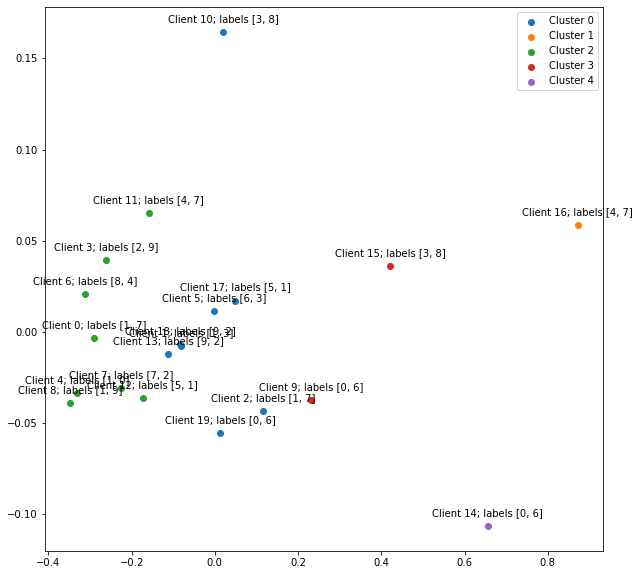

 66%|██████▌   | 99/150 [06:01<03:04,  3.62s/it]

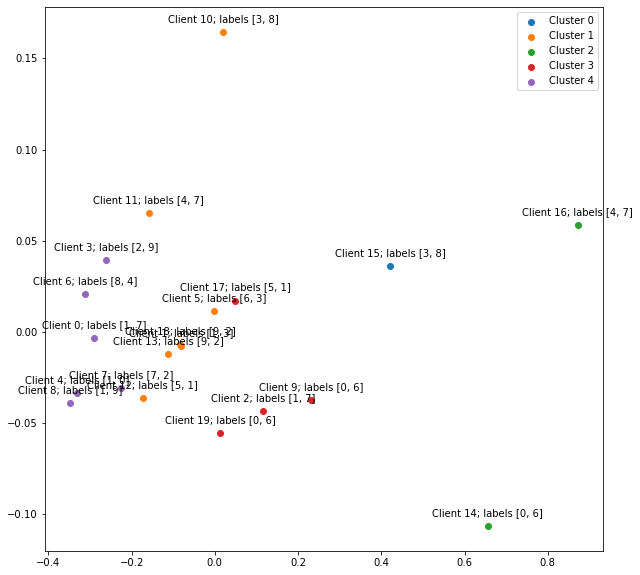

 99%|█████████▉| 149/150 [09:02<00:03,  3.53s/it]

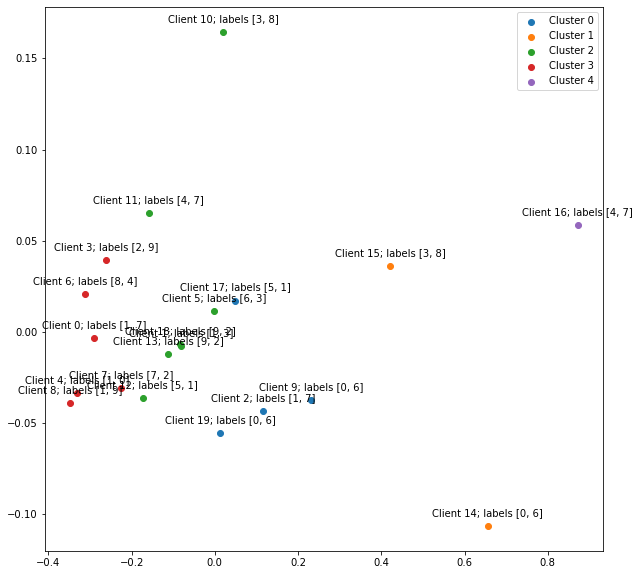

100%|██████████| 150/150 [07:09<00:00,  2.86s/it]


In [24]:
active_rate = 0.2

server_cluster = Server()
server_cluster.FL_training(sampling_method='cluster', rounds=150)
server_IS = Server()
server_IS.FL_training(sampling_method='IS', rounds=150)
server_random = Server()
server_random.FL_training(sampling_method='random', rounds=150)
#server_random.plot_loss()

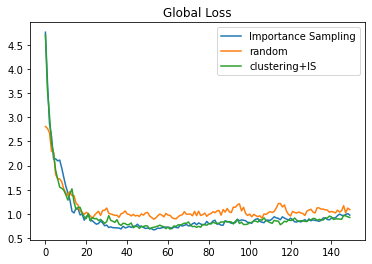

In [25]:
plt.plot(server_IS.loss_list, label='Importance Sampling')
plt.plot(server_random.loss_list, label='random')
plt.plot(server_cluster.loss_list, label='clustering+IS')
plt.legend()
plt.title("Global Loss")
plt.show()